# Imports & Setup

In [2]:
import json
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm_notebook as tqdm
#%matplotlib notebook 
%matplotlib inline 

# Helper Functions

In [3]:
#Fast calculate running mean - x is array, N is window
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

#Normalizes a list between 0-1
def normalize(x):
    max_x = max(x)
    return [i/max_x for i in x]

#Gets frame from file or already opened capture
#NOT WORKING
def getFrame(video, frame):
    
    cap = cv2.VideoCapture()
    cap.open(video)

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame)

    cap.open(video)
    ret, frame = cap.read()
    cap.release()
    
    return frame

#Computes the d'th gradient of array-like x
def gradient(x, d=1):
    temp = x
    for i in range(d):
        temp = np.gradient(temp)
    return temp
        

<p>Once we have the tools to capture specific frames, we can find specific points in the video from motion analysis where there is low movement to feed to the CNN. Below shows the frame grabbing functionality, but for some reason, that is not the correct frame!</p>

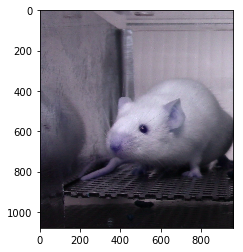

In [14]:
frame = getFrame('assets/esncr.ms12pain51.mp4', 1000)
plt.imshow(frame[:, 0:int(frame.shape[:2][1]/2)], cmap=plt.cm.gray)

In [15]:
#Rough function to grab a bunch of images from a video (for training data)
def grab_images(video):
    cap = cv2.VideoCapture(video)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    ret, frame = cap.read()
    height, width = frame.shape[:2]

    for i in tqdm(range(frames)):
        
        ret, frame = cap.read()
    
        #Change this value to determine how often to grab frames
        if i%(90*5) != 0:
            continue
            
        #Videos each contain 2 mouse cages, l & r    
        left = frame[:, :int(width/2)]
        right = frame[:, int(width/2):]
        cv2.imwrite('imgs/' + video + 'l' + str(int(i/(60*5))) + '.jpg', left)
        cv2.imwrite('imgs/' + video + 'r' + str(int(i/(60*5))) + '.jpg', right)
        
    cap.release()
    
#grab_images(video = 'video2.mp4')
#grab_images(video = 'video3.mp4')

# Motion Analysis

In [17]:
#tracks movement over time of mouse in two-cage setup
def calculate_motion(video, data = [], show_frames = False, learning_rate = 0.0, cage = 'left'):
    
    data.clear()
    
    if show_frames:
        cv2.startWindowThread()
    
    #open the video in opencv and create the mask -- mask options?
    cap = cv2.VideoCapture(video)
    fgbg1 = cv2.createBackgroundSubtractorMOG2()

    #total number of frames in video
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    #grab one frame to determing height and width - don't want to calculate every time
    ret, frame = cap.read()
    height, width = frame.shape[:2]
    
    for i in tqdm(range(frames)):
        
        ret, frame = cap.read()
        
        #If this happens more than a few times, something is wrong with the vid or cv2       
        if not ret:
            print('Failed to capture frame.' + str(i))
            continue
        
        #Shrink the image
        if(cage == 'left' or cage == 'l'):
            frame = cv2.resize(frame[:, 0:int(width/2)],None,fx=.4, fy=.4, interpolation = cv2.INTER_AREA)
        elif(cage == 'right' or cage == 'r'):
            frame = cv2.resize(frame[:, int(width/2):0],None,fx=.4, fy=.4, interpolation = cv2.INTER_AREA)
        else:
            print('Invalid Cage - must be left (l), or right (r)')
            return
    
        fgmask = fgbg1.apply(frame, learning_rate)

        #Sums the 'changed' pixels over the whole image
        data.append(int(np.sum(fgmask)))
    
        if show_frames:
            cv2.imshow('original',frame)
            cv2.imshow('frame - MOG',fgmask)
    
            c = cv2.waitKey(1)
            if 'q' == chr(c & 255):
                break  
    
    if show_frames:
        cap.release()
        cv2.destroyAllWindows()
    
    #save list as .npy file with same name as video
    np.save(video, data)
    
    return np.array(data)


In [18]:
#pain_data = calculate_motion('esncr.ms12pain51.mp4', learning_rate = 0.01)
#baseline_data = calculate_motion('hpvxb.ms34sham15.mp4', learning_rate = 0.01)

pain_data = np.load('esncr.ms12pain51.mp4.npy')
baseline_data = np.load('hpvxb.ms34sham15.mp4.npy')

In [19]:
def prepare_and_plot(data, running_mean_window = 300, head = None, tail = None):
    
    trimmed_data = data[head:tail]
    
    def runningMeanFast(x, N):
        return np.convolve(x, np.ones((N,))/N)[(N-1):]
    
    def normalize(x):
        max_x = max(x)
        return [i/max_x for i in x]
    
    running_mean = runningMeanFast(trimmed_data, running_mean_window)
    
    #Normalizing running mean from 0-1
    max_rm = max(running_mean)      
    normalized_rm = [i/max_rm for i in running_mean]
    
    #Normalizing raw data from 0-1
    max_raw = max(trimmed_data)   
    normalized_raw = [i/max_raw for i in trimmed_data]

    plt.plot(normalized_rm, color = 'red')
    plt.plot(normalized_raw, color = 'grey', alpha = 0.1)
    
    #plt.xticks(range(0,int(max(time)+2)))
    plt.xlabel('time (frame)')
    plt.ylabel('movement (normalized)')
    plt.title('Movement tracking')
    plt.show()

## Baseline

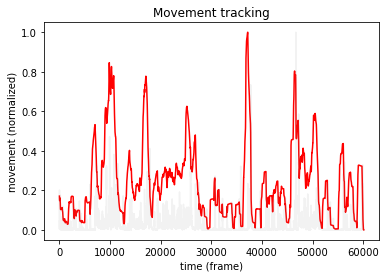

In [20]:
prepare_and_plot(baseline_data, head = 10, running_mean_window = 1000)

## Pain

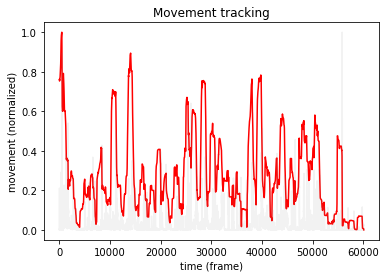

In [21]:
prepare_and_plot(pain_data, head = 10, running_mean_window = 1000)

## Comparison

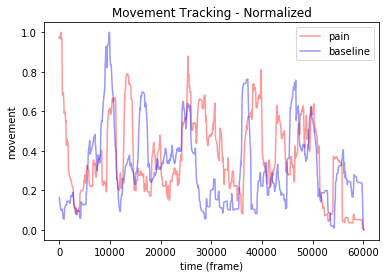

In [25]:
end = min(len(pain_data),len(baseline_data))

pain_rm = normalize(runningMeanFast(pain_data, 1*30*60))[:end]
baseline_rm = normalize(runningMeanFast(baseline_data, 1*30*60))[:end]

plt.plot(pain_rm, 'r', alpha = 0.4, label = 'pain')
#plt.axhline(y=np.average(pain_rm), color='r', linestyle='--')
plt.plot(baseline_rm, 'b', alpha = 0.4, label = 'baseline')
#plt.axhline(y=np.average(baseline_rm), color='b', linestyle='--')

plt.xlabel('time (frame)')
plt.ylabel('movement')
plt.title('Movement Tracking - Normalized')
plt.legend()
plt.show()

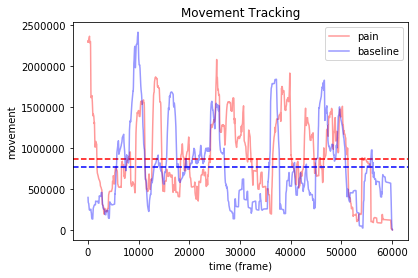

p-value of t-test between pain and baseline data: 5.60484469179e-38


In [26]:
end = min(len(pain_data),len(baseline_data))

pain_rm = runningMeanFast(pain_data, 1*30*60)[:end]
baseline_rm = runningMeanFast(baseline_data, 1*30*60)[:end]

plt.plot(pain_rm, 'r', alpha = 0.4, label = 'pain')
plt.axhline(y=np.average(pain_rm), color='r', linestyle='--')
plt.plot(baseline_rm, 'b', alpha = 0.4, label = 'baseline')
plt.axhline(y=np.average(baseline_rm), color='b', linestyle='--')

plt.xlabel('time (frame)')
plt.ylabel('movement')
plt.title('Movement Tracking')
plt.legend()
plt.show()

from scipy import stats
print('p-value of t-test between pain and baseline data:', stats.ttest_ind(pain_data, baseline_data)[1])

<b>Conclusion:</b> The important aspect of this motion analysis is to determine more exactly where to grab frames from over the span of the video. From visual inspection, picking frames with low movement would still yeild correct classifications, but would enable faster video classification, as fewer frames need to be analyzed. 

<h3> Currently Working On</h3>
<b>FIX FRAME GRAB:</b> Apparantly openCV, the most reputable library for image/video analysis, does not have a reliable way to pull particular frames (that I have found yet).

<h3>Potential Future Work</h3>
Some timeseries analysis may be possible to find more optimal places to grab frames. For example, we could use the gradients to find and pull frames only where the biggest shifts in movement happen.

In [36]:
pain_rm_d1 = gradient(pain_rm)
pain_rm_d2 = gradient(pain_rm, 2)

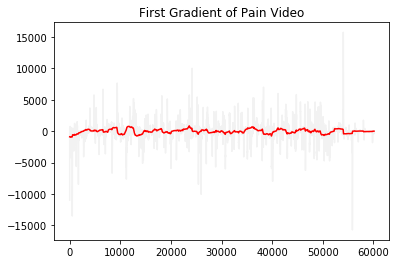

In [39]:
plt.plot(pain_rm_d1, color = 'grey', alpha = 0.1)
plt.plot(runningMeanFast(pain_rm_d1,1*30*60), color = 'red')

plt.title('First Gradient of Pain Video')
plt.show()


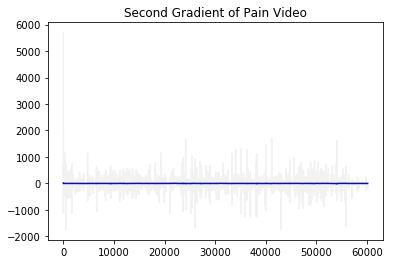

In [40]:
plt.plot(pain_rm_d2, color = 'grey', alpha = 0.1)
plt.plot(runningMeanFast(pain_rm_d2,1*30*60), color = 'blue')

plt.title('Second Gradient of Pain Video')
plt.show()
